# **IMPORT LIBS**

## Import

In [1]:
import numpy as np
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML, BPR, PMF
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
import os
import pickle

In [2]:
import sys
sys.path.append('../Lib')  # Adjusts path to include the Lib directory where utilities.py is located

In [3]:
from helper import *

In [4]:
REPEAT_TRAINING = False

# **GENERATE THE DATASET**

## Init

In [5]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

# **MODEL CHOICE**

In [6]:
# Here I won't comment anything, we are just using the code provided by the authors of the paper

raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['max_user'] = 15401
raw_data['max_item'] = 1001
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')

MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "yahoo"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)


if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


# **EVALUATION**

In [7]:
# Load data
raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")
raw_data['max_user'] = 15401
raw_data['max_item'] = 1001
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

# Load data
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])

In [8]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()
tf.set_random_seed(seed)

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load model
model.load(OUTPUT_PATH)

# Set parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 200
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-20 15:28:21.946042: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-08-20 15:28:21.948878: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4192055000 Hz
2024-08-20 15:28:21.949400: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556993939020 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-20 15:28:21.949420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ./generated_data/cml-yahoo/
[Subsampling negative items]


## Biased Evaluation

In [9]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
model_trainer._evaluate_partial(test_dataset_pos_biased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
model_trainer._evaluate_partial(test_dataset_neg_biased)

100%|██████████| 2296/2296 [00:25<00:00, 90.50it/s]


{'AUC': [0.5039491525423728,
  0.5153220338983051,
  0.5071644295302014,
  0.5041442953020134,
  0.4916666666666667,
  0.4769661016949153,
  0.5358892617449664,
  0.5279222972972972,
  0.5011577181208055,
  0.4937878787878789,
  0.517864406779661,
  0.5050675675675675,
  0.4627638190954774,
  0.4978,
  0.5228472222222221,
  0.4881879194630873,
  0.5278595317725752,
  0.48707482993197276,
  0.5023322147651007,
  0.5379797979797981,
  0.5238127090301004,
  0.5319349315068492,
  0.486571906354515,
  0.4471644295302013,
  0.4835451505016722,
  0.4724295774647888,
  0.49429553264604814,
  0.48894648829431436,
  0.4587074829931973,
  0.5340909090909091,
  0.4631711409395972,
  0.5076094276094276,
  0.47067708333333336,
  0.5034782608695653,
  0.47471476510067107,
  0.49164429530201337,
  0.5371070234113712,
  0.46685374149659864,
  0.4741442953020134,
  0.5084966216216217,
  0.5023986486486486,
  0.43272413793103454,
  0.552098976109215,
  0.47006734006734013,
  0.4715604026845638,
  0.49927

## Unbiased Evaluation

In [10]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 2296/2296 [00:01<00:00, 1566.94it/s]


{'AUC': [0.46611111111111103,
  0.5780000000000001,
  0.5166666666666666,
  0.5066666666666667,
  0.49222222222222217,
  0.4635714285714285,
  0.38833333333333336,
  0.5835714285714285,
  0.454375,
  0.46444444444444444,
  0.369375,
  0.43357142857142855,
  0.5721428571428572,
  0.45875,
  0.465,
  0.5116666666666667,
  0.47388888888888886,
  0.5149999999999999,
  0.4992857142857144,
  0.5127777777777778,
  0.493125,
  0.47,
  0.32944444444444443,
  0.45,
  0.675,
  0.33062499999999995,
  0.79,
  0.490625,
  0.393125,
  0.5744444444444443,
  0.19714285714285712,
  0.5222222222222223,
  0.46499999999999997,
  0.49833333333333335,
  0.4600000000000001,
  0.692857142857143,
  0.6625,
  0.3825,
  0.51,
  0.40785714285714286,
  0.5125,
  0.480625,
  0.62125,
  0.506,
  0.41444444444444445,
  0.50375,
  0.49000000000000005,
  0.2225,
  0.4888888888888888,
  0.4677777777777778,
  0.5438888888888889,
  0.5429999999999999,
  0.4666666666666666,
  0.39888888888888885,
  0.41333333333333333,
  0.

# **COMPUTE RESULTS**

In [11]:
GAMMAS = [1.5,2,2.5,3]

## Calculate Propensities

precaluclating propensities

In [12]:
propensities = calculate_propensities(15401,1001, output_name+"training_arr.npy",normalize=True)

In [13]:
propensities

{1.5: array([[0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        ...,
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943],
        [0.        , 0.29915924, 0.00843328, ..., 0.05913756, 0.01114638,
         0.01399943]]),
 2: array([[0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
        ...,
        [0.        , 0.23500814, 0.00324486, ..., 0.03359202, 0.00453483,
         0.00596118],
    

Compute AOA and unbiased evaluator metrics with biased testset.

In [14]:
biased_results = dict()

biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=30)

for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    biased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30)

Compute AOA and unbiased evaluator metrics with unbiased testset.

In [15]:
unbiased_results = dict()

# unbiased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=100)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=1)
for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    unbiased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1)

Get partitions.

In [16]:
# Get number of items
num_items = 1000

# Get the n_p partitions
n_p = 300
nums = np.arange(1, num_items+1)
partitions = np.random.choice(nums, n_p, replace=False)

# Visualize
partitions

array([ 742,  967,  141,  707,  751,   24,  273,  958,  193,  200, 1000,
        206,  783,  662,  295,  384,  228,  974,  340,  122,  146,  740,
        818,  747,  346,  852,  849,  579,   20,  284,  197,  727,  910,
        332,  251,  599,  529,  463,  192,  873,  502,  309,  731,   11,
        366,  581,  108,  400,  294,  524,  486,  265,  530,  445,  883,
        476,  168,  672,   38,  666,  983,  848,    7,  874,  356,    2,
        490,  545,  954,  365,  189,  701,  992,   99,  823,  885,  128,
        832,  680,  804,  654,  329,  521,  746,  691,  318,   55,  936,
        715,  429,  768,   40,   51,  506,  458,   18,  244,  648,  409,
        548,  694,  567,  730,  411,  864,  172,  272,   15,  227,  427,
        606,  917,  809,  646,  515,  838,  651,  511,  266,  420,  861,
         62,   46,  290,  522,  372,   93,   19,  773,  793,  302,  886,
         26,  705,  781,  395,  456,  957,  785,  483,  334,  644,  536,
        937,  156,  577,  297,  704,  561,  617,  8

Compute the partition which minimizes the sum of AUC and Recall

In [17]:
# Compute biased and unbiased results with stratified for each partition
# and store biased and unbiased results such that the sum of AUC and Recall is minimized

# Value of gamma to use for minimization
gamma = 1.5

# To print :)
key = "STRATIFIED_" + str(gamma).replace(".","")
print(key)

unbiased_results[key] = {}
biased_results[key] = {}
best_partition = np.random.choice(nums, 1)[0]
best_score = float('inf')

history = np.full(1000, np.inf)  # Adjusted to match the size of nums

for p in tqdm(partitions):
    # Fetch stratified results; these functions need to be defined or replaced with actual logic
    temp_unbiased = stratified(OUTPUT_PREFIX + "-test-pos-unbiased_evaluate_partial.pickle",
                               OUTPUT_PREFIX + "-test-neg-unbiased_evaluate_partial.pickle",
                               output_name + "training_arr.npy", propensities[gamma], K=1, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX + "-test-pos-biased_evaluate_partial.pickle",
                             OUTPUT_PREFIX + "-test-neg-biased_evaluate_partial.pickle",
                             output_name + "training_arr.npy", propensities[gamma], K=30, partition=p)

    # Calculate combined score
    combined_score = temp_unbiased['bias'] + temp_unbiased['concentration'] + \
                     temp_biased['bias'] + temp_biased['concentration']

    history[p-1] = combined_score  # Store the combined score

    # Update the best_partition and best_score if the current partition's score is lower
    if combined_score < best_score:
        best_score = combined_score
        best_partition = p

print(f"Best partition: {best_partition} with combined score: {best_score}")
print(f"Minimum score from history: {np.min(history)}")


STRATIFIED_15


  0%|          | 0/300 [00:00<?, ?it/s]

Best partition: 26 with combined score: 24860163.979074456
Minimum score from history: 24860163.979074456


So, for the chosen value of gamma, the best partition is...

In [18]:
# Additional outputs for verification
print("Detailed scores from history:", history)

Detailed scores from history: [              inf 33214201.55640008 30980305.27942323               inf
 28389304.45856429               inf 27818545.99469841               inf
 27260497.93998905               inf 26372049.44067401 26224500.79289838
               inf               inf 25698084.38735908               inf
               inf 25279100.94026098 25153528.78027375 25110612.4680917
               inf 24930641.53299935               inf 24901089.51418758
               inf 24860163.97907446               inf               inf
               inf 24886029.41761388               inf               inf
 24961213.82292649               inf               inf               inf
               inf 25146247.31386617               inf 25226527.66710548
               inf               inf 25437276.635281                 inf
               inf 25740810.14904466               inf               inf
               inf               inf 26067501.01168453               inf
               inf    

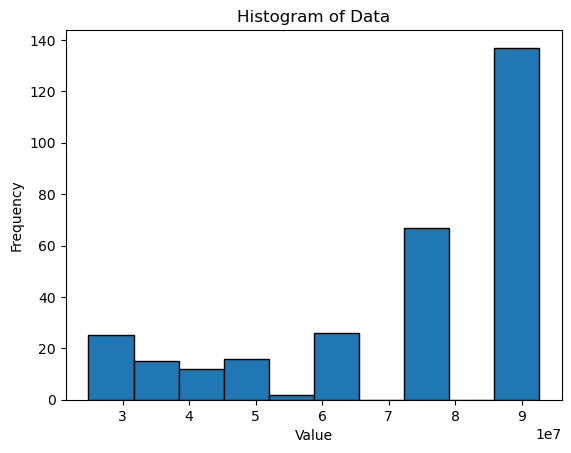

In [19]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(history[history != np.inf], bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display the plot
plt.show()

Compute stratified metrics with biased and unbiased testset.

In [20]:
for gamma in GAMMAS:
    key = "STRATIFIED_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)

This version uses the linspace of items instead of linspace of propensities to make the partition.

In [21]:
for gamma in GAMMAS:
    key = "STRATIFIED_v2_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)


Prepare table for results.

In [22]:
rows = 0
columns = len(biased_results.keys())

for key in biased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

for key in unbiased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

rows, columns

(4, 13)

In [23]:
# Init dictionary
mae_results = dict()

# Get the names of the rows
list_biased_res = list(biased_results.keys())

# Init results
results_array = np.zeros((rows,columns))

Fill the table with the MAE results.

In [24]:
# For each row
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each column
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

# **RESULTS**

In [25]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.154493,0.128429,0.125081,0.122529,0.120581,7.452342e-02,1.044027e-01,5.232920e-01,2.959661e+00,1.766697e-01,1.839236e-01,1.942401e-01,2.081015e-01
1,recall,0.377779,0.259048,0.247508,0.238948,0.232533,3.804937e-01,7.391036e-01,1.862985e+00,6.968291e+00,3.113402e-01,3.123362e-01,3.190871e-01,3.315199e-01
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,6.045104e+05,1.593391e+06,4.080629e+06,1.124921e+07,2.594886e+04,3.198120e+04,3.850664e+04,4.564317e+04
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,1.087198e+06,4.444143e+06,1.864733e+07,7.879304e+07,8.823507e+06,4.303283e+07,2.044720e+08,9.538392e+08
